In [21]:
from binance.client import Client
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
INPUT_FILE= "API_KEYS.txt"

with open(INPUT_FILE, 'r', encoding='utf-8') as file:
    contenu_liste = file.read()

KEYS = contenu_liste.split(',')
KEYS = [element.strip() for element in KEYS]

api_key = KEYS[0]
api_secret = KEYS[1]
client = Client(api_key,api_secret)

In [30]:
info = client.get_account()
# Commission Rates
maker_rate = info['commissionRates']['maker']
taker_rate = info['commissionRates']['taker']

# Convert to seconds (Python's datetime uses seconds)
date_sec = info['updateTime'] / 1000 
# Format the timestamp into a readable date
formatted_date = datetime.fromtimestamp(date_sec, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')

print(f"Binance account : SCL")
print(f"Date : {formatted_date}")

print(f"Maker Rate : {maker_rate}")
print(f"Taker Rate : {taker_rate}")

Binance account : SCL
Date : 2024-12-21 03:16:12
Maker Rate : 0.00100000
Taker Rate : 0.00100000


In [84]:
df_account_crypto = pd.DataFrame(info['balances'])
# Convert 'free' column to numeric
df_account_crypto['free'] = pd.to_numeric(df_account_crypto['free'])
# Filter rows where 'free' > 0
df_account_crypto = df_account_crypto[df_account_crypto['free'] > 0]
# Remove the 'locked' column
df_account_crypto = df_account_crypto.drop(columns=['locked'])
# Supprimer les lignes où 'asset' est 'ETHW' ou 'LDUSDC'
df_account_crypto = df_account_crypto[~df_account_crypto['asset'].isin(['ETHW', 'LDUSDC'])]
reference = 'USDT'
df_account_crypto["pair"] = df_account_crypto["asset"] + reference 

# Fonction personnalisée pour appliquer les formules
def apply_formula(row):
    if row['asset'] == 'USDT':
        return row['free'] * 1
    else:
        return row['free'] * float(client.get_avg_price(symbol=row['pair'])['price'])

# Appliquer la fonction pour créer la nouvelle colonne 'value_in_usdt'
df_account_crypto['reference'] = df_account_crypto.apply(apply_formula, axis=1)

# Sort
df_account_crypto = df_account_crypto.sort_values(by='reference', ascending=False)
# Calcul du pourcentage de chaque ligne par rapport au total de la colonne 'reference'
total_reference = df_account_crypto['reference'].sum()
df_account_crypto['percentage_of_total'] = (df_account_crypto['reference'] / total_reference) * 100

# Désactiver la notation scientifique pour l'affichage
df_account_crypto['percentage_of_total'] = df_account_crypto['percentage_of_total'].apply(lambda x: '{:.1f}'.format(x))

df_account_crypto

,asset,free,pair,reference,percentage_of_total
0,BTC,0.00604,BTCUSDT,594.98446,51.0
239,SOL,1.99800,SOLUSDT,391.67681,33.6
11,USDT,176.26531,USDTUSDT,176.26531,15.1
4,BNB,0.00275,BNBUSDT,1.87069,0.2
158,USDC,0.98628,USDCUSDT,0.98660,0.1
2,ETH,0.00010,ETHUSDT,0.34511,0.0
545,PEPE,0.16000,PEPEUSDT,0.00000,0.0


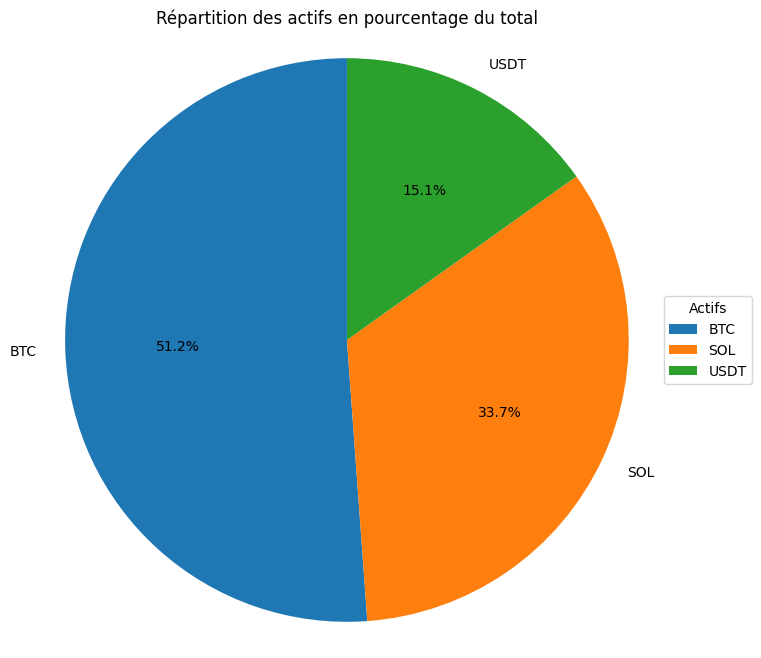

In [88]:
# Filtrer les actifs dont la valeur est inférieure à 1%
df_account_crypto['percentage_of_total'] = df_account_crypto['percentage_of_total'].astype(float)
filtered_df = df_account_crypto[df_account_crypto['percentage_of_total'] >= 1]

# Créer un pie chart pour les actifs filtrés
plt.figure(figsize=(8, 8))  # Taille du graphique
plt.pie(filtered_df['percentage_of_total'], labels=filtered_df['asset'], autopct='%1.1f%%', startangle=90)

# Ajouter un titre
plt.title('Répartition des actifs en pourcentage du total')

# Afficher la légende uniquement pour les actifs avec un pourcentage >= 1%
plt.legend(filtered_df['asset'], title='Actifs', loc='center left', bbox_to_anchor=(1, 0.5))

# Afficher le graphique
plt.axis('equal')  # Assure que le pie chart est un cercle
plt.show()

In [96]:
# Binance Earn 
savings_data = client.get_simple_earn_account()
print(savings_data)

{'totalAmountInBTC': '0.01018426', 'totalAmountInUSDT': '1001.63443897', 'totalFlexibleAmountInBTC': '0.01018426', 'totalFlexibleAmountInUSDT': '1001.63443897', 'totalLockedInBTC': '0', 'totalLockedInUSDT': '0'}
